In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gpflow.kernels import SquaredExponential
from gpflow.likelihoods import Gaussian
from gpflow import set_trainable
from gpflow.models import SSGPMC, SGLD
from gpflow.utilities import to_default_float, print_summary
from gpflow.config import set_default_jitter
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import gpflow
tfd = tfp.distributions
f64 = to_default_float
import tensorflow as tf
import numpy as np
%matplotlib inline
set_default_jitter(1e-4)

/home/pindert2/.local/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


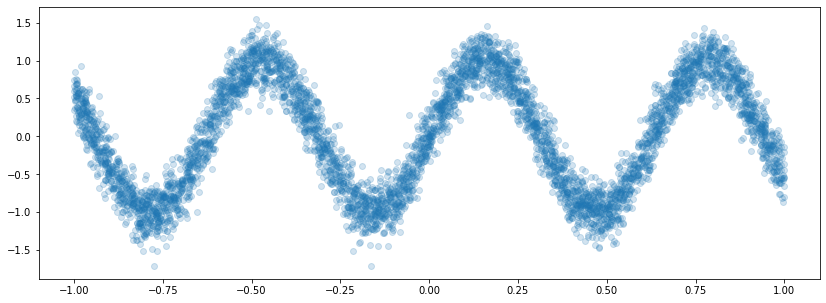

In [6]:
rng = np.random.RandomState(123)
tf.random.set_seed(42)


def func(x):
    return np.sin(10*x)
       


N = 5000  # Number of training observations

X = rng.rand(N, 1) * 2 - 1  # X values
Y = func(X) + 0.2 * rng.randn(N, 1)  # Noisy Y values

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(X, Y, 'o', alpha=0.2)

log posterior density pre-optimisation: -5942.752528752004
log posterior density post-optimisation: 785.4039593644243


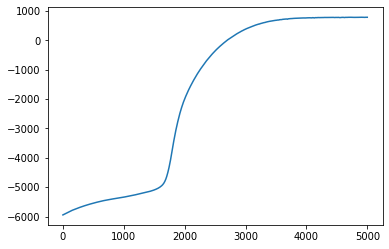

In [7]:
data = (X, Y)
M = 50  # Number of inducing locations

minibatch_size = 100
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)
train_iter = iter(train_dataset.batch(minibatch_size))

kernel = SquaredExponential()
Z = X[:M, :].copy(
)  # Initialize inducing locations to the first M inputs in the dataset

m = SSGPMC(kernel=kernel,
           likelihood=Gaussian(),
           inducing_variable=Z,
           num_data=N)

set_trainable(m.inducing_variable, False)

print(f"log posterior density pre-optimisation: {m.log_posterior_density(data)}")
training_loss = m.training_loss_closure(train_iter, compile=True)
opt = tf.optimizers.Adam()
logfs = []
for i in range(5000):
    opt.minimize(training_loss, m.trainable_variables)
    logfs.append(m.log_posterior_density(data))
print(f"log posterior density post-optimisation: {m.log_posterior_density(data)}")

plt.plot(logfs)

In [8]:
m.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
m.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
m.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

# We turn off training for inducing point locations
print(f"log posterior density post-optimisation: {m.log_posterior_density(data)}")
print_summary(m, fmt='notebook')

log posterior density post-optimisation: 782.6810118662061


name,class,transform,prior,trainable,shape,dtype,value
SSGPMC.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,2.4732701603018437
SSGPMC.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.20773653455055613
SSGPMC.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.041940803365898095
SSGPMC.inducing_variable.Z,Parameter,,,False,"(50, 1)",float64,[[0.39293837...
SSGPMC.V,Parameter,,Normal,True,"(50, 1)",float64,[[-0.43456366...


## Visualise inducing point locations

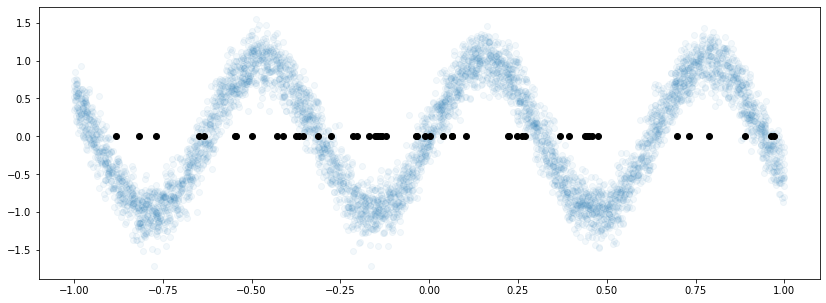

In [9]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(X, Y, 'o', alpha=0.05)
ax.plot(m.inducing_variable.Z.numpy(), np.zeros_like(m.inducing_variable.Z.numpy()), 'o', color='black')

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(
        (X, Y)).repeat().shuffle(N)

opt = SGLD(m, train_dataset)

In [11]:
samples = opt.run(10000, 0.01, 256)

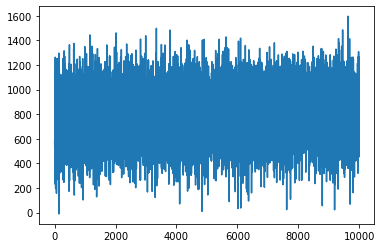

In [12]:
plt.plot(opt.history)

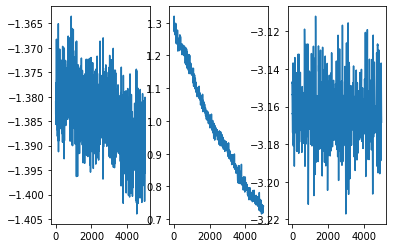

In [13]:
n_burn = 5000
thin = 10

chain = np.vstack([h[1:] for h in samples])
chain.shape
fig, ax = plt.subplots(nrows=1, ncols=3)
for a, c in zip(ax.ravel(), chain[n_burn:, :].T):
    a.plot(c)

In [19]:
Xtest = np.linspace(-1.5, 1.5, 200).reshape(-1, 1)
preds = []

chain_samples = samples[n_burn:]

for sample in chain_samples[::thin]:
    m.V.unconstrained_variable.assign(sample[0])
    m.kernel.lengthscales.unconstrained_variable.assign(sample[1])
    m.kernel.variance.unconstrained_variable.assign(sample[2])
    m.likelihood.variance.unconstrained_variable.assign(sample[3])
    preds.append(m.predict_f_samples(Xtest).numpy())
# mu, sigma = m.predict_y(Xtest)

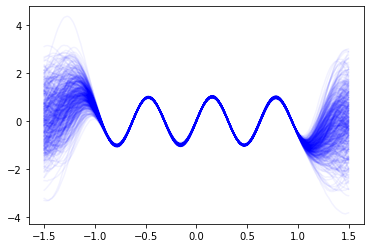

In [20]:
for pred in preds:
    plt.plot(Xtest, pred, alpha=0.05, color='blue')

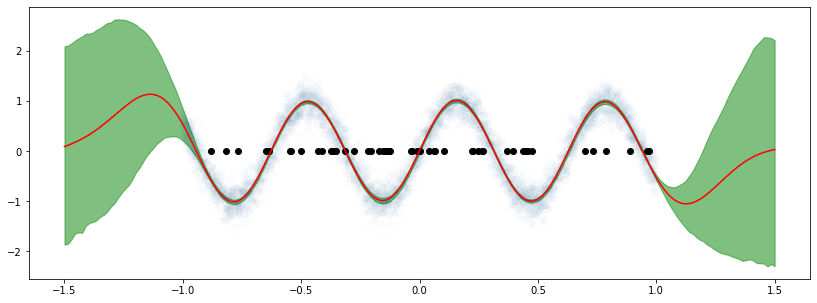

In [41]:
mu = np.mean(preds, axis=0)
lower, upper = np.percentile(preds, q=[2.5, 97.5],axis=0)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(X, Y, 'o', alpha=0.01)
ax.plot(m.inducing_variable.Z.numpy(), np.zeros_like(m.inducing_variable.Z.numpy()), 'o', color='black')
mur = mu.ravel()
sigmar = sigma.ravel()
ax.plot(Xtest, mu, color='red')
ax.fill_between(Xtest.ravel(), lower.ravel(), upper.ravel(), color='green', alpha=0.5);


(200, 1)